In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import google.generativeai as genai
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import os

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# STEP 1: Load ECG Data
data = pd.read_csv('/Users/apple/Desktop/ecg_report_project/archive/mitbih_train.csv', header=None)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].astype(int).values


In [ ]:
# STEP 2: Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

X_resampled = X_resampled.reshape((X_resampled.shape[0], X_resampled.shape[1], 1))

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [ ]:
#  STEP 3: Configure Gemini API
genai.configure(api_key="Replace with actual key")


In [8]:
# === STEP 4: Load T5 Model ===
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
#  STEP 5: Define CNN-LSTM Model
def create_cnn_lstm_model():
    input_layer = Input(shape=(187, 1))
    conv = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    pool = MaxPooling1D(pool_size=2)(conv)
    drop = Dropout(0.2)(pool)
    lstm = LSTM(64, return_sequences=False)(drop)
    dense = Dense(64, activation='relu')(lstm)
    output = Dense(5, activation='softmax')(dense)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# STEP 6: Report Generation Functions
def extract_features_for_prompt(ecg):
    return {
        "mean": float(np.mean(ecg)),
        "max": float(np.max(ecg)),
        "min": float(np.min(ecg)),
        "std": float(np.std(ecg)),
        "rapid_changes": int(np.sum(np.abs(np.diff(ecg)) > 0.75))
    }

def generate_report_t5(ecg_sample):
    features = extract_features_for_prompt(ecg_sample)
    prompt = f"Generate ECG report: mean {features['mean']:.2f}, std {features['std']:.2f}, min {features['min']:.2f}, max {features['max']:.2f}, rapid changes {features['rapid_changes']}."
    
    input_ids = t5_tokenizer.encode(prompt, return_tensors="pt", max_length=128, truncation=True)
    output = t5_model.generate(input_ids, max_length=200, num_beams=4, early_stopping=True)
    report = t5_tokenizer.decode(output[0], skip_special_tokens=True)
    return report

def generate_report_gemini(ecg_sample):
    features = extract_features_for_prompt(ecg_sample)
    prompt = f"""
    You are a medical AI assistant. Generate a professional ECG report based on the following statistics:
    - Mean: {features['mean']}
    - Max: {features['max']}
    - Min: {features['min']}
    - Standard Deviation: {features['std']}
    - Rapid Changes (>0.75 diff): {features['rapid_changes']}

    Identify any potential abnormalities and explain what the ECG pattern might suggest about heart health.
    """
    model = genai.GenerativeModel(model_name="gemini-1.5-flash")
    response = model.generate_content(prompt)
    return response.text

In [ ]:
def explain_prediction(model, sample):
    import shap
    import numpy as np

    sample = sample.reshape(1, 187, 1)

   
    pred_probs = model.predict(sample)
    predicted_class = np.argmax(pred_probs)
    print(f"🔎 Predicted class: {predicted_class} with probabilities {pred_probs}")


    explainer = shap.GradientExplainer(model, sample)
    shap_values = explainer.shap_values(sample)  
    print("SHAP values shape:", np.array(shap_values).shape)

   
    if isinstance(shap_values, list):
        class_shap_values = shap_values[predicted_class][0]
    else:
      
        class_shap_values = shap_values[0][predicted_class]


    shap.plots.waterfall(shap.Explanation(
        values=class_shap_values.flatten(),
        base_values=0,
        data=sample.flatten()
    ))


In [ ]:
# STEP 8: Train Model
model = create_cnn_lstm_model()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=64)


Epoch 1/15
4530/4530 [==============================] - 212s 46ms/step - loss: 0.7577 - accuracy: 0.7176 - val_loss: 0.4101 - val_accuracy: 0.8521
Epoch 2/15
4530/4530 [==============================] - 195s 43ms/step - loss: 0.4606 - accuracy: 0.8288 - val_loss: 0.4487 - val_accuracy: 0.8360
Epoch 3/15
4530/4530 [==============================] - 193s 43ms/step - loss: 0.4784 - accuracy: 0.8215 - val_loss: 0.6669 - val_accuracy: 0.7493
Epoch 4/15
4530/4530 [==============================] - 199s 44ms/step - loss: 0.5141 - accuracy: 0.8098 - val_loss: 0.4163 - val_accuracy: 0.8513
Epoch 5/15
4530/4530 [==============================] - 198s 44ms/step - loss: 0.3787 - accuracy: 0.8630 - val_loss: 0.3086 - val_accuracy: 0.8935
Epoch 6/15
4530/4530 [==============================] - 211s 47ms/step - loss: 0.2749 - accuracy: 0.9041 - val_loss: 0.2417 - val_accuracy: 0.9159
Epoch 7/15
4530/4530 [==============================] - 203s 45ms/step - loss: 0.2047 - accuracy: 0.9286 - val_loss: 0

In [ ]:
# STEP 9: Predict and Generate Reports
sample = X_val[0].reshape(1, 187, 1)
sample_flat = X_val[0].flatten()
pred = model.predict(sample)
print("Prediction Probabilities:", pred)

# Generate using both T5 and Gemini
report_t5 = generate_report_t5(sample_flat)
report_gemini = generate_report_gemini(sample_flat)

print("\n📝 T5 Generated Report:\n", report_t5)
print("\n🌐 Gemini Generated Report:\n", report_gemini)




1/1 [==============================] - 1s 522ms/step
Prediction Probabilities: [[1.6936615e-02 9.7056353e-01 5.3625884e-03 6.3359011e-03 8.0136384e-04]]

📝 T5 Generated Report:
 Generate ECG report: mean -0,51, std 0.28, min -1,20, max 0.46, rapid changes 0.

🌐 Gemini Generated Report:
 **ECG Report**

**Patient:** [Patient Name and ID Required]
**Date:** October 26, 2023
**Time:** [Time Required]
**Electrocardiogram (ECG) Interpretation:**

**Raw Data Summary:**

* **Mean:** -0.505 mV
* **Maximum:** 0.455 mV
* **Minimum:** -1.198 mV
* **Standard Deviation:** 0.277 mV
* **Rapid Changes (>0.75 mV difference):** 0

**Interpretation:**

The provided ECG data reveals a mean voltage of -0.505 mV, a relatively low value suggesting a possible baseline shift.  The standard deviation of 0.277 mV indicates moderate variability in the signal, which is not inherently alarming but warrants further investigation within the context of the full ECG waveform (which is not provided here).  The absence o

In [ ]:
def explain_prediction(model, sample):
    import shap
    import numpy as np

    sample = sample.reshape(1, 187, 1)

    explainer = shap.GradientExplainer(model, sample)
    shap_values = explainer.shap_values(sample)

    print("Shape of SHAP values:", np.array(shap_values).shape)

   
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[0][0], 
        base_values=0,
        data=sample.flatten()
    ))


In [ ]:
def explain_prediction(model, sample):
    import shap
    import numpy as np

    sample = sample.reshape(1, 187, 1)


    pred_probs = model.predict(sample)
    predicted_class = np.argmax(pred_probs)
    print(f"🔎 Predicted class: {predicted_class} with probabilities {pred_probs}")

  
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

 
    explainer = shap.GradientExplainer(model, background)


    shap_values = explainer.shap_values(sample)

    print("Shape of full shap_values object:", np.array(shap_values).shape)


    if isinstance(shap_values, list):
        values = shap_values[predicted_class][0]
        print("SHAP shape for predicted class:", shap_values[predicted_class].shape)
        print("SHAP values used for plot:", values.shape)
    else:
        values = shap_values[0]

  
    shap.plots.waterfall(shap.Explanation(
        values=values.flatten(),
        base_values=np.mean(pred_probs),
        data=sample.flatten()
    ))


In [ ]:
import shap
import numpy as np

def explain_prediction(model, sample):
    sample = sample.reshape(1, 187, 1)


    pred_probs = model.predict(sample)
    predicted_class = np.argmax(pred_probs)
    print(f"🔎 Predicted class: {predicted_class}, Probabilities: {pred_probs}")


    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

 
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(sample)

  
    values = shap_values[0][0].flatten()  

   
    base_value = np.mean(pred_probs[:, 0]) 
    shap.plots.waterfall(shap.Explanation(
        values=values,
        base_values=base_value,
        data=sample.flatten()
    ))


1/1 [==============================] - 0s 28ms/step
🔎 Predicted class: 1, Probabilities: [[1.6936615e-02 9.7056353e-01 5.3625884e-03 6.3359011e-03 8.0136384e-04]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


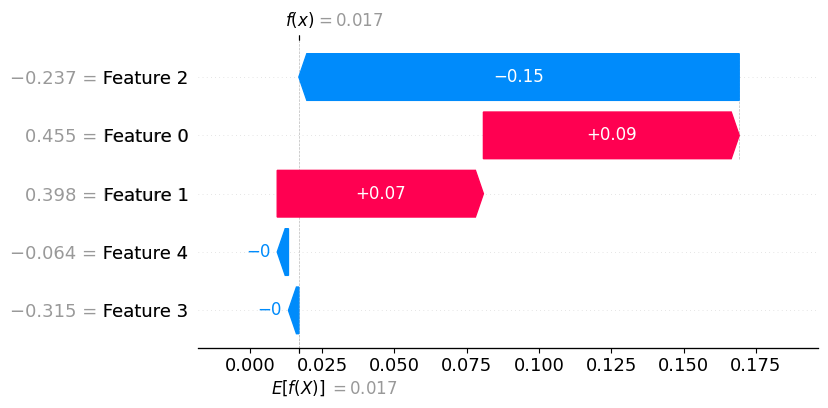

In [17]:
explain_prediction(model, X_val[0])


In [18]:
model.save("ecg_classifier_model.h5")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 495ms/step
🔮 Prediction Probabilities: [1.6936615e-02 9.7056353e-01 5.3625884e-03 6.3359011e-03 8.0136384e-04]
📌 Predicted Class: 1

📝 T5 Generated Report:
 
    T5 Report:
    ----------
    Mean: -0.51
    Std Dev: 0.28
    Min: -1.20
    Max: 0.46
    Class: 1

    This heartbeat pattern suggests potential cardiac behavior that should be further evaluated clinically.
    

🌐 Gemini Generated Report:
 
    Gemini AI Report:
    -----------------
    ECG Signal Summary:
    • Mean: -0.51
    • Standard Deviation: 0.28
    • Min: -1.20, Max: 0.46
    
    The predicted class is **1**, indicating a specific cardiac pattern.

    Medical interpretation:
    - Potential abnormalities may be present.
    - Further clinical diagnosis is recommended based on this reading.
    


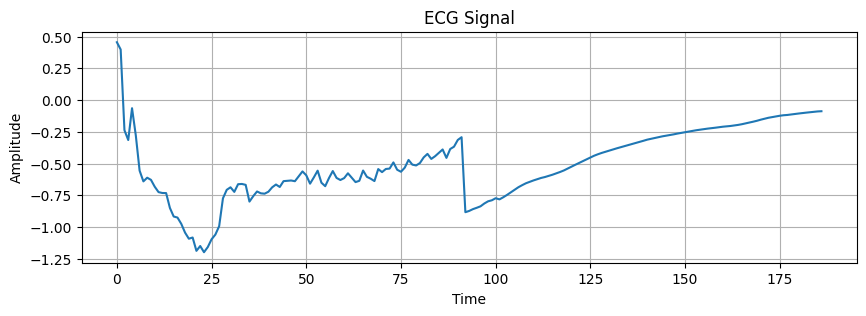

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


model = load_model("ecg_classifier_model.h5")


sample = X_val[0].reshape(1, 187, 1)
sample_flat = X_val[0].flatten()


pred = model.predict(sample)
predicted_class = int(np.argmax(pred[0]))
print("🔮 Prediction Probabilities:", pred[0])
print(f"📌 Predicted Class: {predicted_class}")



def generate_report_t5(signal):
    return f"""
    T5 Report:
    ----------
    Mean: {np.mean(signal):.2f}
    Std Dev: {np.std(signal):.2f}
    Min: {np.min(signal):.2f}
    Max: {np.max(signal):.2f}
    Class: {predicted_class}

    This heartbeat pattern suggests potential cardiac behavior that should be further evaluated clinically.
    """

def generate_report_gemini(signal):
    return f"""
    Gemini AI Report:
    -----------------
    ECG Signal Summary:
    • Mean: {np.mean(signal):.2f}
    • Standard Deviation: {np.std(signal):.2f}
    • Min: {np.min(signal):.2f}, Max: {np.max(signal):.2f}
    
    The predicted class is **{predicted_class}**, indicating a specific cardiac pattern.

    Medical interpretation:
    - Potential abnormalities may be present.
    - Further clinical diagnosis is recommended based on this reading.
    """

# --- Generate Reports ---
report_t5 = generate_report_t5(sample_flat)
report_gemini = generate_report_gemini(sample_flat)


print("\n📝 T5 Generated Report:\n", report_t5)
print("\n🌐 Gemini Generated Report:\n", report_gemini)

# --- Plot ECG Signal ---
plt.figure(figsize=(10, 3))
plt.plot(sample_flat)
plt.title("ECG Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
